[View in Colaboratory](https://colab.research.google.com/github/mzhang32/nanohub-project/blob/master/first_submodel.ipynb)

#First Submodel
Refer to the design document [here](https://docs.google.com/document/d/1BM18EP8cWlJ371yYBoru_q8MHjesn3eBKg7CYRqPmv0/edit). We're using GitHub to back up and Google Drive to collaborate. I believe this tool(Google Colab) will be useful because it is highly collaborative and easy to use.

In [10]:
!pip install PySpice


Traceback (most recent call last):
  File "/Applications/anaconda/bin/pip", line 7, in <module>
    from pip import main
  File "/Applications/anaconda/lib/python3.5/site-packages/pip/__init__.py", line 26, in <module>
    from pip.utils import get_installed_distributions, get_prog
  File "/Applications/anaconda/lib/python3.5/site-packages/pip/utils/__init__.py", line 27, in <module>
    from pip._vendor import pkg_resources
  File "/Applications/anaconda/lib/python3.5/site-packages/pip/_vendor/pkg_resources/__init__.py", line 3018, in <module>
    @_call_aside
  File "/Applications/anaconda/lib/python3.5/site-packages/pip/_vendor/pkg_resources/__init__.py", line 3004, in _call_aside
    f(*args, **kwargs)
  File "/Applications/anaconda/lib/python3.5/site-packages/pip/_vendor/pkg_resources/__init__.py", line 3046, in _initialize_master_working_set
    dist.activate(replace=False)
  File "/Applications/anaconda/lib/python3.5/site-packages/pip/_vendor/pkg_resources/__init__.py", line 257

In [8]:
!pip install scipy

Traceback (most recent call last):
  File "/Applications/anaconda/bin/pip", line 7, in <module>
    from pip import main
  File "/Applications/anaconda/lib/python3.5/site-packages/pip/__init__.py", line 26, in <module>
    from pip.utils import get_installed_distributions, get_prog
  File "/Applications/anaconda/lib/python3.5/site-packages/pip/utils/__init__.py", line 27, in <module>
    from pip._vendor import pkg_resources
  File "/Applications/anaconda/lib/python3.5/site-packages/pip/_vendor/pkg_resources/__init__.py", line 3018, in <module>
    @_call_aside
  File "/Applications/anaconda/lib/python3.5/site-packages/pip/_vendor/pkg_resources/__init__.py", line 3004, in _call_aside
    f(*args, **kwargs)
  File "/Applications/anaconda/lib/python3.5/site-packages/pip/_vendor/pkg_resources/__init__.py", line 3046, in _initialize_master_working_set
    dist.activate(replace=False)
  File "/Applications/anaconda/lib/python3.5/site-packages/pip/_vendor/pkg_resources/__init__.py", line 257

In [9]:
import numpy as np
import math
import scipy

from scipy.linalg import *

ImportError: 
Importing the multiarray numpy extension module failed.  Most
likely you are trying to import a failed build of numpy.
If you're working with a numpy git repo, try `git clean -xdf` (removes all
files not under version control).  Otherwise reinstall numpy.

Original error was: cannot import name 'multiarray'


###Write a function that finds the minimum distance between a pair of 3D line segments.

In [23]:
"""Distance returns the 3D distance between line1=(start1, end1) and
line2=(start2, end2)."""
def distance(line1, line2):
  P = np.array(line1[0])
  Q = np.array(line1[1])
  R = np.array(line2[0])
  S = np.array(line2[1])
  P1mP0 = Q - P
  Q1mQ0 = S - R
  P0mQ0 = P - R
  a = np.dot(P1mP0, P1mP0)
  b = np.dot(P1mP0, Q1mQ0)
  c = np.dot(Q1mQ0, Q1mQ0)         
  d = np.dot(P1mP0, P0mQ0)
  e= np.dot(Q1mQ0, P0mQ0)
  det = a * c - b * b
  if det > 0:
    bte = b * e
    ctd = c * d
    if bte <= ctd: # s <= 0
      s = 0
      if e <= 0:  # t <= 0
        t = 0
        nd = -d
        if nd >= a:
          s = 1
        elif nd > 0:
          s = nd / a
      elif e < c:  #0 < t < 1 and region 5
        t = e / c
      else: # t >= 1
        t = 1   # region 4
        bmd = b - d
        if bmd >= a:
          s = 1
        elif bmd > 0:
          s = bmd / a
    else: 
      s = bte - ctd
      if s >= det:
        s = 1
        bpe = b + e
        if bpe <= 0: # region 8
          t = 0
          nd = -d
          if nd <= 0:
            s = 0
          elif nd < a:
            s = nd / a
        elif bpe < c: # region 1
          t = bpe / c
        else: # region 2
          t = 1
          bmd = b- d
          if bmd <= 0:
            s = 0
          elif bmd < a:
            s = bmd / a
      else:
        ate = a * e
        btd = b * d
        if ate <= btd: # region 7 
          t = 0
          nd = -d
          if nd <= 0:
            s = 0
          elif nd >= a:
            s = 1
          else:
            s = nd / a
        else: 
          t = ate - btd
          if t >= det: # region 3
            t = 1
            bmd = b - d
            if bmd <= 0:
              s = 0
            elif bmd >= a:
              s = 1
            else:
              s = bmd / a
          else:  # region 0
            s /= det
            t /= det
  else: 
    if e <= 0:
      t = 0
      nd = -d
      if nd <= 0: # region 6
        s = 0
      elif nd >=a: # region 8
        s = 1
      else: # region 7
        s = nd / a
    elif e >= c:
      t = 1
      bmd = b - d
      if bmd <= 0: # reigon 4
        s = 0
      elif bmd >= a: # region 2
        s = 1
      else:  # region 3
        s = bmd / a
    else:       
      """The point (0,e/c) is on the line and domain, so we have one
      point at which R is a minimum."""
      s = 0
      t = e / c

  result_parameter = [s, t]
  result_closest = [P + s * P1mP0, R + t * Q1mQ0]
  diff = result_closest[1] - result_closest[0]
  dist = np.dot(diff, diff)
  dist = math.sqrt(dist)
  
  return dist
  
# Compute the euclidian distance between p1=(x1,y1,z1) and p2=(x2,y2,z2)
def simple_distance(p1, p2):
  x1 = p1[0]
  x2 = p2[0]
  y1 = p1[1]
  y2 = p2[1]
  z1 = p1[2]
  z2 = p2[2]
  return np.sqrt((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2)



###Given a set of inputs about angle distribution and nanotube length and filament size, generate some line segments .


In [24]:
# Rewriting the code because I can't figure out what's wrong with the above.
import numpy as np
import math
"""Returns volume of polymer given width(of square side) and length."""
def get_polymer_volume(width_of_poly, length_of_poly):
    return (width_of_poly ** 2) * length_of_poly

"""Returns volume of cylindrical nanowire with diameter and length."""
def get_wire_volume(length, diameter):
    return math.pi * ((diameter / 2) ** 2) * length
  
"""Returns a random point within the domain. """ 
def get_initial_point(width_of_poly, length_of_poly):
    x = np.random.uniform(-(width_of_poly / 2), (width_of_poly / 2))
    y = np.random.uniform(0, length_of_poly)
    z = np.random.uniform(0, width_of_poly)
    return (x, y, z)

"""Returns an end point for the corresponding start_point within the domain. """
def get_end_point(p, mean, sd, phi_lower, phi_upper, theta_lower, theta_upper):
    length = np.random.normal(mean, sd)
    phi = np.random.uniform(phi_lower, phi_upper)
    theta = verti_angle = np.random.uniform(theta_lower, theta_upper)
    x = p[0] + length * math.sin(theta) * math.cos(phi)
    y = p[1] + length * math.sin(theta) * math.sin(phi)
    z = p[2] + length * math.cos(theta)
    p_end = fix_domain(p, [x, y, z])
    final_length = simple_distance(p, p_end)
    return tuple(p_end), final_length
  
"""Returns True if the line (point1, point2) has a distamce that is 
   greater than or equal to diameter away from all the lines defined by
   start_points, end_points."""  
def check_intersection(lines, point1, point2, diameter, int_tol):
    for line in lines:
        dist = distance(line, (point1, point2))
        if dist < diameter - int_tol:
            return False
    return True

"""Return True if the points (x, y, z) is not within the polymer. """
def check_domain(p):
    return p[1] > length_of_poly or p[2] > width_of_poly or p[2] < 0 \
                or abs(p[0]) > (width_of_poly / 2)

"""Given initial point p0 and a line (p0, p1), adjust p1 so it lies 
   within the domain."""
def fix_domain(p0, p1):
  a = p1[0]-p0[0]
  b = p1[1]-p0[1]
  c = p1[2]-p0[2]
  if p1[0] > width_of_poly / 2:
    p1[0] = width_of_poly / 2
    t = (p1[0]-p0[0])/a
    p1[1] = p0[1] + t*b
    p1[2] = p0[2] + t*c
  elif p1[0] < -width_of_poly / 2:
    p1[0] = -width_of_poly / 2
    t = (p1[0]-p0[0])/a
    p1[1] = p0[1] + t*b
    p1[2] = p0[2] + t*c
  if p1[1] > length_of_poly:
    p1[1] = length_of_poly
    t = (p1[1]-p0[1])/b
    p1[0] = p0[0] + t*a
    p1[2] = p0[2] + t*c
  elif p1[1] < 0:
    p1[1] = 0
    t = (p1[1]-p0[1])/b
    p1[0] = p0[0] + t*a
    p1[2] = p0[2] + t*c  
  if p1[2] > width_of_poly:
    p1[2] = width_of_poly
    t = (p1[2]-p0[2])/c
    p1[0] = p0[0] + t*a
    p1[1] = p0[1] + t*b
  elif p1[2] < 0:
    p1[2] = 0
    t = (p1[2]-p0[2])/c
    p1[0] = p0[0] + t*a
    p1[1] = p0[1] + t*b
  return p1
  
  
"""Returns a list of lines where each line is [(x1, y1, z1), (x2, y2, z2)]."""
def generate(volume_fraction, width_of_poly, length_of_poly, diameter, 
            volume_of_poly, mean_nanowire_length, SD, theta_lower, 
            theta_upper, phi_lower, phi_upper, int_tol):
	lines = []
	volume = 0
	while (volume / volume_of_poly) < volume_fraction:
		start = get_initial_point(width_of_poly, length_of_poly)
		end, length = get_end_point(start, mean_nanowire_length, SD, phi_lower, phi_upper, theta_lower, theta_upper)
		while (int_tol != diameter and not check_intersection(lines, start, end, diameter, int_tol)):
			start = get_initial_point(width_of_poly, length_of_poly)
			end, length = get_end_point(start, mean_nanowire_length, SD, phi_lower, phi_upper, theta_lower, theta_upper)
		lines.append([start, end])
		volume += math.pi * ((diameter / 2) ** 2) * length
    
	return lines
      
     
    
    

In [25]:
volume_fraction = 3/100 # 1% generates about 2500 nanowires, 2% about 5000(normal dimensions), 3% gets you connecting path(halved volume)
width_of_poly = 25/4 # 25/1.26
length_of_poly = 25/4 # 25/1.26
diameter = 125e-3
volume_of_poly = get_polymer_volume(width_of_poly, length_of_poly)
mean_nanowire_length = 5
SD = 1.5e-3
theta_lower = 0
theta_upper = math.pi
phi_lower = 0
phi_upper = math.pi
cross_sectional_area = (diameter / 2) ** 2 * math.pi
intersection_tolerance = diameter/2 # Let the nanowires intersect a 
                                    # little, set to 0 if no want intersect, set to diameter if disregard intersect
lines = generate(volume_fraction, width_of_poly, 
                                   length_of_poly, diameter, 
                                   volume_of_poly, mean_nanowire_length, 
                                   SD, theta_lower, theta_upper, 
                                   phi_lower, phi_upper, 
                                   intersection_tolerance)

In [81]:
# Testing distance
l1 = [(0, 0, 0), (1, 0, 0)]
l2 = [(2, 0, 0), (3, 0, 0)]
l3 = [(0, 0, 1), (1, 0, 1)]
l4 = [(0, -1, 0), (1, -1, 0)]
l5 = [(0, 0, 0), (1, 1, 0)]
l6 = [(0, 0, 1), (1, 0, 2)]
print(distance(l1, l2))
print(distance(l1, l3))
print(distance(l1, l4))
print(distance(l5, l6))

# Testing start and end points
distances = []
for i in range(len(lines)):
  for j in range(i):
    l1 = lines[i]
    l2 = lines[j]
    d = distance(l1, l2)
    if d < diameter:
      print("Uh oh")
      distances.append(d)

print("Distances should be empty if int_tol is 0: ", sorted(distances))     
print(len(distances))

1.0
1.0
1.0
1.0
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Uh oh
Distances should be empty if int_tol is 0:  [0.06267301351642185, 0.06348249463121006, 0.06404624493204367, 0.06445236128687604, 0.06483253793708642, 0.06595108674252494, 0.06611506555343459, 0.0663376913348006, 0.06680738267687282, 0.06683978809887613, 0.06703362377787844, 0.06715828290113798, 0.06721581631340895, 0.06739010051780568, 0.06783520900866367, 0.0695250192979014, 0.070488803

In [74]:
len(lines)

146

###Represent the distribution of the nanowires and the distances between them as a graph.
Let G = (V, E) where V is the set of indiviual nanowires and let E = (V1, V2), the distance between nanowires V1 and V2. Using the graph package library [NetworkX](https://networkx.github.io/documentation/stable/tutorial.html).

In [5]:
!pip install networkx

In [82]:
import networkx as nx

""" Returns a networkx graph G formed from V = the lines in format 
 [(x1, y1, z1), (x2, y2, z2)] and E = distances between the lines
 that are within tolerance.
"""
def init_graph(lines, tolerance):
  G = nx.Graph()
  G.add_nodes_from(range(len(lines)))
  for i in range(len(lines)):
    for j in range(i):
      l1 = lines[i]
      l2 = lines[j]
      d = distance(l1, l2)
      if d <= tolerance:
        G.add_edge(i, j, weight=d*1e-6)  # Units unscaled
  return G


In [83]:
H = init_graph(lines, diameter*1)   
H_prime = init_graph(lines, diameter*1.5)

In [0]:
list(H.edges.data('weight'))

 ### Graphically visualize the model.
 We may have to import some libraries. A good-looking one is this python wrapper for OpenGL, [PyOpenGL](http://pyopengl.sourceforge.net/).
 
 It turns out using opengl in python notebook is not possible(?).

In [28]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

segments = []
for line in lines:
  x = [line[0][0], line[1][0]]
  y = [line[0][1], line[1][1]]
  z = [line[0][2], line[1][2]]
  segments.append([x, y, z])
for seg in segments:
  ax.plot(seg[0], seg[1], seg[2])
ax.set_xlim3d(-width_of_poly/2, width_of_poly/2)
ax.set_ylim3d(0, length_of_poly)
ax.set_zlim3d(0, length_of_poly)  
plt.xlabel('x')
plt.ylabel('y')  
#ax.plot([0, -1], [0, -1], [0, -1]) # Test line segment
plt.show()  


<ESC>2018-07-11 10:36:32,055<ESC> - <ESC>matplotlib.wrapper<ESC> - <ESC>DEBUG<ESC> - $HOME=/Users/Michelle
<ESC>2018-07-11 10:36:32,056<ESC> - <ESC>matplotlib.wrapper<ESC> - <ESC>DEBUG<ESC> - matplotlib data path /Applications/anaconda/lib/python3.5/site-packages/matplotlib/mpl-data
<ESC>2018-07-11 10:36:32,063<ESC> - <ESC>matplotlib.rc_params_from_file<ESC> - <ESC>DEBUG<ESC> - loaded rc file /Applications/anaconda/lib/python3.5/site-packages/matplotlib/mpl-data/matplotlibrc
<ESC>2018-07-11 10:36:32,065<ESC> - <ESC>matplotlib.<module><ESC> - <ESC>DEBUG<ESC> - matplotlib version 2.2.2
<ESC>2018-07-11 10:36:32,065<ESC> - <ESC>matplotlib.<module><ESC> - <ESC>DEBUG<ESC> - interactive is False
<ESC>2018-07-11 10:36:32,066<ESC> - <ESC>matplotlib.<module><ESC> - <ESC>DEBUG<ESC> - platform is darwin
<ESC>2018-07-11 10:36:32,066<ESC> - <ESC>matplotlib.<module><ESC> - <ESC>DEBUG<ESC> - loaded modules: ['prompt_toolkit.filters', 'getpass', 'numpy._import_tools', 'encodings.latin_1', 'ipython_genu

ImportError: dlopen(/Applications/anaconda/lib/python3.5/site-packages/matplotlib/ft2font.cpython-35m-darwin.so, 2): Symbol not found: _inflateValidate
  Referenced from: /Applications/anaconda/lib/libpng16.16.dylib
  Expected in: /Applications/anaconda/lib/python3.5/lib-dynload/../../libz.1.dylib
 in /Applications/anaconda/lib/libpng16.16.dylib

### Use the graph to compute a conductive cluster.
1. Graph theory is great. Details are in the working. The paper used the Union-Find Algorithm :
*"To find the conductive cluster in a nanotube system
between two electrodes and to calculate the probability of
percolation, an algorithm based on the graph theory is used.
According to the algorithm, all tubes of the system are
represented as vertices of a simple graph, edges of which
correspond to the connections between the tubes. Nanotubes
that are in contact with the opposite sides of the parallelepiped
form two subsets corresponding to the electrode. At the next
stage, a component that combines these subsets is sought by
means of the union-find algorithm. Thus, a conductive path in
the nanotubes system is formed.""* From [Computer Simulation of Field-Controlled Percolation
in 3D System of Straight Nanotubes](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8365699&tag=1).

2. Add in model for electrical conductivity of nanowires to calculate material properties in domain.


In [89]:
H.edges.data('weight')

EdgeDataView([(0, 2131, 1.0594446722523573e-07), (1, 2337, 7.432877764952751e-08), (1, 2483, 1.1286742810023002e-07), (1, 2495, 6.374826374525983e-08), (2, 2210, 1.2006249586562257e-07), (2, 2804, 6.584126109417616e-08), (3, 2719, 9.743363280888911e-08), (4, 950, 9.579201494484675e-08), (4, 1617, 8.307664928294931e-08), (5, 870, 6.512834680677863e-08), (6, 685, 8.933917445616958e-08), (6, 957, 7.35432364574879e-08), (6, 1359, 8.938087332974506e-08), (6, 2534, 7.44278787148117e-08), (8, 1364, 6.572431050431779e-08), (8, 1516, 1.0164365944184338e-07), (8, 1526, 1.0461113450346195e-07), (9, 969, 7.377977147826668e-08), (9, 2279, 7.83228388098006e-08), (10, 2421, 8.043546696589176e-08), (11, 1557, 1.011734289882281e-07), (13, 933, 6.819399613944487e-08), (13, 2655, 8.736216768081547e-08), (15, 514, 8.34117283272747e-08), (15, 2520, 1.035332058792001e-07), (17, 581, 1.1209464025354967e-07), (17, 1832, 7.252831140324831e-08), (17, 3061, 1.0107915839092849e-07), (18, 714, 1.1775749221474388e-

In [26]:
def is_between(b1, x, b2):
   return (b1 <= x and x <= b2) or (b2 <= x and x <= b1)

""" Given the length of the cross-section, a list of segments 
 [(x1, x2), (y1, y2), (z1, z2)], and graph G return a 
 connecting cluster from source(y~0) to sink(y~length). If none, 
 return None. 
"""
def find_connecting_cluster(length, segs, G):
  source_plane = length/100
  sink_plane = length - length/100
  
  
  n = range(len(segs))
  source_segs = [i for i in n if is_between(segs[i][1][0], 
                                            source_plane, segs[i][1][1])]
  sink_segs = [i for i in n if is_between(segs[i][1][0], 
                                          sink_plane, segs[i][1][1])]
  
  if not source_segs or not sink_segs:
    print("No nanotubes intersecting source and/or sink planes.")
    return None
  
  # Iteratively grow the connecting cluster beginning from the source.
  H = nx.Graph()
  H.add_nodes_from(source_segs)
  new_segs = source_segs
  while new_segs:
    temp = list(new_segs)
    new_segs = []
    for seg in temp:
      for v in G.neighbors(seg):
        if v not in sink_segs and v not in H.nodes():
          new_segs.append(v)
        H.add_edge(seg, v, weight=G[seg][v]['weight'])  
  
  # Iteratively grow from the sink to get the final cluster.
  K = nx.Graph()
  K_sinks, K_sources = set(), set()
  new_segs = [v for v in H.nodes() if v in sink_segs]
  K_sinks = set(new_segs)
  K.add_nodes_from(new_segs)
  path_exists = False
  while new_segs:
    temp = list(new_segs)
    new_segs = []
    for seg in temp:
      for v in H.neighbors(seg):
        if v not in source_segs and v not in K.nodes():
          new_segs.append(v)
        if v in source_segs:
          K_sources.add(v)
        K.add_edge(seg, v, weight=G[seg][v]['weight'])  
  if not K_sources:
    print("No connecting paths.")
    return None, None, None
  print("There are %d nanowires in the cluster out of all %d nanowires." % (len(K.nodes()), len(segments)))
  return K, K_sources, K_sinks

      
  
  

In [27]:
K, K_sources, K_sinks = find_connecting_cluster(length_of_poly, segments, H)
if K:
  K, K_sources, K_sinks = find_connecting_cluster(length_of_poly, segments, H_prime) 
  

NameError: name 'segments' is not defined

### Compute conductivity.
Use the equation from this paper: [Conductivity size effect of polycrystalline metal nanowires](https://aip.scitation.org/doi/full/10.1063/1.4967198)

In [87]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from numpy import sqrt, sin, cos, pi, exp, log

# cond_g is the conductivity in presence of both GBS and BS
# lambda_0 is background mean free path
# a is nanowire radius
# p is proportion of elastically scattered electrons
# v is the velocity vector magnitude
# r is the radius vector
# alpha is the 
# d = D is the avg grain diameter
# R is the reflection probability of an electron at a single plane.

def total_conductivity(a, lambda_0, R, d, theta, cond_0, p):
  # C = D/(2*a) = 1
  k = 2*a/lambda_0
  t = 1/sin(theta)
  alpha = (lambda_0/d)*(R/(1-R))
  cond_g = 3*cond_0*(1/3 - .5*alpha + alpha**2 - alpha**3*log(1 + 1/alpha))
  H = 1 + alpha/(1-1/t**2)**.5
  f1 = lambda t : (-1/(H)**2)*(t**-5)*sqrt(t**2 - 1)
  #print('<2>')
  integral_1 = integrate.quad(f1, 1, np.inf) 
  #print('<3>')
  #print(integral_1)
  # Approximate the geometric series
  def sum_of_series(max):
    total = 0
    for v in range(max):
      f2 = lambda psi : (exp(-(v+1)*H*k*t*sin(psi)) - exp(-v*H*k*t*sin(psi)))*sin(psi)
      integral_2 = integrate.quad(f2, 0, pi/2)
      total = total + p**v * integral_2[0]
    return total
  
  total_cond = cond_g - (12/(pi*k))*(1-p)*integral_1[0]*sum_of_series(10)
  
  return total_cond
  
  

In [88]:
def calc_resistance(total_cond, cross_sectional_area, length):
    resistivity = 1 / total_cond
    resistance = (resistivity * length) / cross_sectional_area
    return resistance

###Graphically visualize the model with a connecting cluster.

There are 12 nanowires in the cluster out of all 274 nanowires.


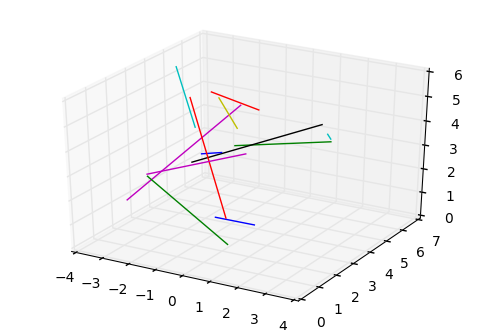

In [89]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
K = find_connecting_cluster(length_of_poly, segments, H)[0]
for n in K.nodes():
  seg = segments[n]
  ax.plot(seg[0], seg[1], seg[2])
plt.show()   

###SPICE-y Circuit Simulation

####Design plan:
*   Compute conducivity of each wire, use to find resistance
*   Formulate a graph G' where the nodes are the endpoints of the nanowires, each nanowire has a resistance, and every space between a pair of nanowires that is within some tolerance is a DIODE with some resistance
 * Each edge has a "length"(distance for dielectric edges) and a "resistance"
 * Nodes are named #a, #b where 1 is the the vertex #.
 * Create a voltage source node and a ground node that is adjacent to nodes in the source set and the sink set, respectively.

* Next step: Because dielectric path can connect middles of wires, a wire may have to be broken up into several segments.
* Eventually figure out how to model that space with dielectric breakdown.




In [39]:
# Using experiment (a) with Ag and R=0.3, p=0.4, C=1
cond = total_conductivity(diameter*1e-6/2, diameter*1e-6, 0.3, diameter*1e-6, 1, 6.3e7, .4)

In [90]:
# Compute the length of the segment [(x1, x2), (y1, y2), (z1, z2)].
def get_length(seg):
  x1 = seg[0][0]
  x2 = seg[0][1]
  y1 = seg[1][0]
  y2 = seg[1][1]
  z1 = seg[2][0]
  z2 = seg[2][1] 
  return np.sqrt((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2)


  
# Given the connecting cluster K, return a netlist graph G'.
def make_netlist_graph(K, source_nodes, sink_nodes, diameter):
  N = nx.Graph()
  N.add_node('source')
  N.add_node('sink')
  for v in K.nodes():
    n1 = str(v) + 'a'
    n2 = str(v) + 'b'
    N.add_node(n1)
    N.add_node(n2)
    length = get_length(segments[v])*1e-6
    resistance = calc_resistance(cond, np.pi*(diameter)**2, length)
    N.add_edge(n1, n2, length=length, r=resistance, type='wire')
  for v in source_nodes:
    N.add_edge('source', str(v) + 'a', length=0, r=0, type='source')
    N.add_edge('source', str(v) + 'b', length=0, r=0, type='source')
  for v in sink_nodes:    
    N.add_edge('sink', str(v) + 'a', length=0, r=0, type='sink')
    N.add_edge('sink', str(v) + 'b', length=0, r=0, type='sink')
  for (u, v) in K.edges():
    if (K[u][v]['weight'] > diameter):
      s1 = segments[u]
      s2 = segments[v]
      a1 = (s1[0][0], s1[1][0], s1[2][0])
      b1 = (s1[0][1], s1[1][1], s1[2][1])
      a2 = (s2[0][0], s2[1][0], s2[2][0])
      b2 = (s2[0][1], s2[1][1], s2[2][1])
      d1 = simple_distance(a1, a2)*1e-6
      d2 = simple_distance(a1, b2)*1e-6
      d3 = simple_distance(b1, a2)*1e-6
      d4 = simple_distance(b1, b2)*1e-6
      min_d = min([d1, d2, d3, d4])
      resistance = 1e-5 #Fix this??
      if d1 == min_d:
        N.add_edge(str(u) + 'a', str(v) + 'a', length=d1, r=resistance, type="diode")
      elif d2 == min_d:
        N.add_edge(str(u) + 'a', str(v) + 'b', length=d2, r=resistance, type="diode")
      elif d3 == min_d:
        N.add_edge(str(u) + 'b', str(v) + 'a', length=d3, r=resistance, type="diode")  
      else:
        N.add_edge(str(u) + 'b', str(v) + 'b', length=d4, r=resistance, type="diode")  
    else:
      N.add_edge(str(u) + 'a', str(v) + 'a', length=K[u][v]['weight'], r=0, type="connection")
      #G_prime.add_edge(str(u) + 'b', str(v) + 'b', length=K[u][v]['weight'], r=0, type="connection")

  return N

In [94]:
N = make_netlist_graph(K, K_sources, K_sinks, diameter*1e-6)
N.edges()

[('133b', '133a'),
 ('133b', 'sink'),
 ('176b', 'sink'),
 ('26b', '26a'),
 ('26a', '83a'),
 ('26a', '236a'),
 ('26a', '161a'),
 ('26a', '135a'),
 ('141b', '141a'),
 ('63b', '63a'),
 ('63b', 'source'),
 ('3a', 'sink'),
 ('188b', 'sink'),
 ('176a', 'sink'),
 ('259b', 'sink'),
 ('source', '63a'),
 ('146a', 'sink'),
 ('154b', 'sink'),
 ('236a', '77a'),
 ('236a', '22a'),
 ('236a', '236b'),
 ('236a', '133a'),
 ('246a', 'sink'),
 ('70b', 'sink'),
 ('175b', '175a'),
 ('2b', '2a'),
 ('83a', '141a'),
 ('83a', '83b'),
 ('107b', 'sink'),
 ('22a', '22b'),
 ('63a', '141a'),
 ('161b', '161a'),
 ('56b', 'sink'),
 ('77a', '77b'),
 ('77a', 'sink'),
 ('250a', 'sink'),
 ('107a', 'sink'),
 ('250b', 'sink'),
 ('3b', 'sink'),
 ('133a', 'sink'),
 ('154a', 'sink'),
 ('231b', 'sink'),
 ('135b', '135a'),
 ('188a', 'sink'),
 ('119a', 'sink'),
 ('175a', '2a'),
 ('146b', 'sink'),
 ('sink', '173b'),
 ('sink', '259a'),
 ('sink', '56a'),
 ('sink', '246b'),
 ('sink', '119b'),
 ('sink', '173a'),
 ('sink', '70a'),
 ('sin

In [50]:
import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()

from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
from decimal import Decimal

# Output a netlist from the netlist graph G
def make_netlist(G, source_voltage, die_const):
  fh = open("Test.cir", "w")
  fh.write("***Nanowire Composite Simulation***\n")
  fh.write("* Input Source\n")
  fh.write("Vs source 0 %dV\n" % (source_voltage))
  fh.write("* Resistances of Nanowires, Dielectric modeled as Diodes\n")
  fh.write("Rground sink 0 0\n")
  num_resistors = 0
  num_diodes = 0
  diodes = [] # diode number, breakdown voltage(BV), resistance(RS)
  for u, v in G.edges():
    elem_type = G[u][v]['type']
    resistance = Decimal(G[u][v]['r'])
    if elem_type == 'source' or elem_type == 'sink':
      fh.write("R%i %s %s 0\n" % (num_resistors, u, v))
      num_resistors += 1
    elif elem_type == 'wire':
      fh.write("R%i %s %s %E\n" % (num_resistors, u, v, resistance))
      num_resistors += 1
    elif elem_type == 'diode':
      fh.write("D%i %s %s diode%i\n" % (num_diodes, data[0][0], data[0][1], num_diodes))
#       fh.write("R%i %s %s %E\n" % (num_resistors, data[0][0], data[0][1], Decimal(data[1]['r'])))
#       num_resistors += 1
      bv = die_const * data[1]['length']
      diodes.append([num_diodes, bv, data[1]['r']])
      num_diodes += 1
    else: # Connection type
      fh.write("R%i %s %s 0\n" % (num_resistors, data[0][0], data[0][1]))
      num_resistors += 1      
  for d in diodes:
    fh.write(".model diode%i d (bv=%EV rs=%E)\n" % (d[0], Decimal(d[1]), Decimal(d[2])))

  fh.write(".end")
  
make_netlist(N, 5, 13e6) # ABS material

AttributeError: 'function' object has no attribute 'items'

###Closer Examination of Paths

In [19]:
import random

""" Given the length of the cross-section, a list of segments 
 [(x1, x2), (y1, y2), (z1, z2)], graph G, and a tolerance, return some 
 connecting graph. If none, return None. 
"""
def find_connecting_path(length, segs, G, tol):

  source_plane = length/100
  sink_plane = length - length/100

  H = nx.Graph()
  #X = UnionFind()

  def is_between(b1, x, b2):
    return (b1 <= x and x <= b2) or (b2 <= x and x <= b1)
    

  n = range(len(segs))
  source_segs = [i for i in n if is_between(segs[i][1][0], 
                                            source_plane, segs[i][1][1])]
  sink_segs = [i for i in n if is_between(segs[i][1][0], 
                                          sink_plane, segs[i][1][1])]
  #random.shuffle(source_segs)
  #random.shuffle(sink_segs)
  
  print("Source segments: ", source_segs)
  print("Sink segments: ", sink_segs)
  if not source_segs or not sink_segs:
    print("No nanotubes intersecting source and/or sink planes.")
    return None
  
  H.add_nodes_from(source_segs)
  #X.union(source_segs)
  sink = None
  new_segs = source_segs
  while new_segs:
    # Add contacting tubes to each set.  
    temp = list(new_segs)
    new_segs = []
    for seg in temp:
      for v in G.neighbors(seg):
        if v not in source_segs:
          #X.union(source_segs[0], v)
          new_segs.append(v)
          H.add_edge(seg, v, weight=G[seg][v]['weight'])
          if v in sink_segs:
            sink = v
            return H, sink, source_segs
            

  
  print("No connecting path found.")
  return None
 
"""Returns a path from source to sink given a graph H. """
def get_paths_from_components(H, sink, source_segs):
  ccs = list(nx.connected_components(H))
  # path = max(ccs, key=lambda c:len(c))
  paths = []
  for component in sorted(ccs, key=lambda c:len(c), reverse=True):
    if sink in component:
      for node in component:
        if node in source_segs and nx.has_path(H, node, sink):
          #p = nx.shortest_path(H, node, sink)
          p = nx.all_simple_paths(H, node, sink)
          paths.extend(p)
          #paths.append(p)
  return paths        
    



In [21]:
H, sink, source_segs = find_connecting_path(length_of_poly, segments, H, diameter)
# Getting a path from the cluster
paths = get_paths_from_components(H, sink, source_segs)
for p in paths:
  print(p)
#print("The path: ", path)

#list(H.edges)


Source segments:  [127, 143, 293, 327, 354, 495, 509, 511, 630, 699, 701, 725, 791, 914, 963, 1071, 1110, 1141, 1161, 1369, 1430, 1472, 1548, 1581, 1681, 1729, 1768, 1878, 1894, 2272, 2280, 2448, 2462, 2478, 2507, 2509]
Sink segments:  [7, 17, 112, 131, 483, 487, 736, 804, 903, 1015, 1217, 1277, 1342, 1357, 1427, 1532, 1552, 1588, 1714, 1763, 1785, 1901, 2014, 2019, 2023, 2073, 2531]


KeyboardInterrupt: ignored

###Graphically visualize the model with a path.

No handles with labels found to put in legend.


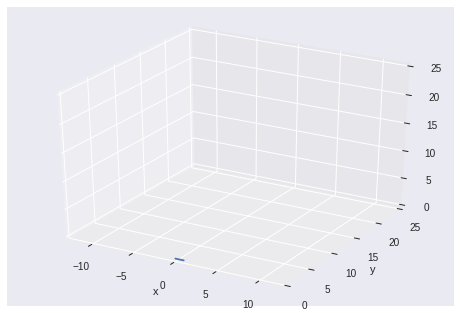

In [72]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
path = paths[0]
for n in path:
  seg = segments[n]
#   ax.plot(seg[0], seg[1], seg[2], label=n)
ax.legend()  
ax.plot([0, 1], [0, 0], [0, 0]) # Test line segment
plt.xlabel('x')
plt.ylabel('y')
ax.set_xlim3d(-width_of_poly/2, width_of_poly/2)
ax.set_ylim3d(0, length_of_poly)
ax.set_zlim3d(0, length_of_poly)
plt.show()  


# for i in range(len(path)-1):
#   u = path[i]
#   v = path[i+1]
#   print("Segment %d to %d has weight %f." % (u, v, H.edges[u, v]['weight']))
# print("The path consists of the following segments: ")
# for n in path:
#   print(segments[n])


###Dingle Conductivity

May complete later. The paper ["The electrical conductivity of thin wires"](https://drive.google.com/drive/u/1/folders/16vq8rsENWgqOa_reLoC_ZGkfnw0MKlvl) has approximate and more exact formulas for conductivity.



In [0]:
dingle(lambda, a):
  k = 2*a/lambda
  

[8.28300045853329, 6.837266230737769, 5.873074944259505, 5.184072730636917, 4.667080810555554, 4.264776205466102, 3.9427639940380415, 3.6791555894879044, 3.459357862271192, 3.273267270801468, 3.113666498041116, 2.9752624259694773, 2.8540848636908933, 2.7470974844070817, 2.6519384462419415, 2.566742919176069, 2.4900188513645882, 2.4205582287069993, 2.357372534627303, 2.299645044998243, 2.246695048134966, 2.1979506509825018, 2.1529278599480786, 2.111214309716738, 2.072456478136048, 2.0363495457732252, 2.002629283111678, 1.9710655075811425, 1.9414567670610912, 1.9136259897310022, 1.8874169013432047, 1.862691056458948, 1.8393253642875265, 1.817210015573455, 1.796246736670417, 1.7763473120899613, 1.7574323285538602, 1.739430102742833, 1.7222757621346643, 1.70591045401808, 1.6902806622977564, 1.6753376153290085, 1.661036770935179, 1.6473373671171427, 1.6342020288789902, 1.6215964231569662, 1.609488955120484, 1.5978505001695762, 1.5866541668260783, 1.5758750864405338, 1.565490226240754, 1.555

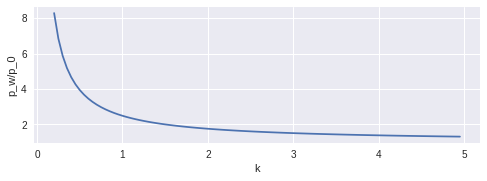

In [38]:
# Using experiment (a) with Ag and R=0.3, p=0.4, C=1
lambda_0 = 125e-9
#cond_0 = 6.3e7 # Silver
C = 1
# Test points for k = 1, 2, 5, 8, 10, 12
#k_list = [.1, .5, 1, 2, 5, 8, 10, 12]
k_list = np.arange(.2, 5, 0.05)
ratio_list = []
for k in k_list:
  a = k*lambda_0*.5
  d = 2*a*C
  #cond_w = total_conductivity(a, lambda_0, .3, d, pi, cond_0, .5)
  cond_0 = 4.1e7 # Gold
  cond_w = total_conductivity(a, lambda_0, .52, d, pi, cond_0, .5)
  ratio_list.append(cond_0/cond_w)
  #print("For k = %.1f we get that p_w/p_0 is %f" % (k, cond_0/cond_w))
print(ratio_list)

# x = np.arange(.1, 25, 0.1)
plt.figure(1)
plt.subplot(211)

plt.plot(k_list, ratio_list)
#plt.axis('square')
plt.xlabel('k')
plt.ylabel('p_w/p_0')
plt.show()

In [61]:
[3.9109067859780144, 3.3370821510976105, 2.9539617838298526, 2.679879869905615, 2.473993311231388, 2.3136044790996517, 2.185089826552471, 2.0797762209083306, 1.9918789083021253, 1.9173910519770736, 1.8534490904261978, 1.7979518878346379, 1.7493226572999607, 1.7063548780589175, 1.6681095493770532, 1.6338448725513637, 1.6029670147524475, 1.574994930025638, 1.5495347666365864, 1.5262609446093178, 1.5049019590630694, 1.4852295869458303, 1.4670505814967014, 1.450200209959396, 1.4345371741160184, 1.4199395801574033, 1.4063017132828635, 1.3935314355061004, 1.3815480704932719, 1.370280672246307, 1.3596665987043195, 1.349650329360915, 1.3401824795166306, 1.3312189740202802, 1.3227203511651968, 1.3146511734170874, 1.3069795263095525, 1.299676590480728, 1.2927162746831204, 1.2860748998595632, 1.279730926177059, 1.2736647163496893, 1.2678583297398884, 1.262295342663922, 1.2569606910885904, 1.2518405325276838, 1.2469221244564987, 1.242193716982655, 1.2376444578588086, 1.2332643082112718, 1.2290439675990192, 1.2249748072186688, 1.2210488102399233, 1.217258518398179, 1.2135969840912264, 1.2100577273288555, 1.2066346969708281, 1.2033222357625388, 1.2001150487408725, 1.1970081746369239, 1.193996959948792, 1.1910770353978035, 1.1882442945161726, 1.185494874144116, 1.1828251366405016, 1.1802316536337605, 1.177711191159547, 1.1752606960488867, 1.1728772834456385, 1.170558225345368, 1.1683009400593316, 1.166102982517538, 1.163962035333874, 1.1618759005642645, 1.1598424920958939, 1.1578598286117745, 1.1559260270805076, 1.1540392967260098, 1.1521979334363974, 1.1504003145751127, 1.148644894160918, 1.146930198386481, 1.1452548214481062, 1.1436174216616677, 1.142016717842073, 1.1404514859256079, 1.138920555816343, 1.1374228084394444, 1.1359571729856963, 1.1345226243329114, 1.1331181806311026, 1.1317429010394064, 1.1303958836037251, 1.1290762632649884, 1.1277832099887342, 1.126515927007468]


    100% |████████████████████████████████| 1.2MB 7.1MB/s 
  Running setup.py bdist_wheel for pyopengl ... - \ | / - \ | / - \ | / - \ | / done
  Stored in directory: /content/.cache/pip/wheels/6c/00/7f/1dd736f380848720ad79a1a1de5272e0d3f79c15a42968fb58
Successfully built pyopengl


In [5]:
import sys
!{sys.executable} -m pip install numpy

Traceback (most recent call last):
  File "/Applications/anaconda/lib/python3.5/runpy.py", line 183, in _run_module_as_main
    mod_name, mod_spec, code = _get_module_details(mod_name, _Error)
  File "/Applications/anaconda/lib/python3.5/runpy.py", line 142, in _get_module_details
    return _get_module_details(pkg_main_name, error)
  File "/Applications/anaconda/lib/python3.5/runpy.py", line 109, in _get_module_details
    __import__(pkg_name)
  File "/Applications/anaconda/lib/python3.5/site-packages/pip/__init__.py", line 26, in <module>
    from pip.utils import get_installed_distributions, get_prog
  File "/Applications/anaconda/lib/python3.5/site-packages/pip/utils/__init__.py", line 27, in <module>
    from pip._vendor import pkg_resources
  File "/Applications/anaconda/lib/python3.5/site-packages/pip/_vendor/pkg_resources/__init__.py", line 3018, in <module>
    @_call_aside
  File "/Applications/anaconda/lib/python3.5/site-packages/pip/_vendor/pkg_resources/__init__.py", line 

In [6]:
import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()
import numpy as np
print(np.version.version)
np.positive(-4)
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *

ImportError: 
Importing the multiarray numpy extension module failed.  Most
likely you are trying to import a failed build of numpy.
If you're working with a numpy git repo, try `git clean -xdf` (removes all
files not under version control).  Otherwise reinstall numpy.

Original error was: cannot import name 'multiarray'


In [4]:
circuit = Circuit('Resistor Bridge')

circuit.V('input', 1, circuit.gnd, 10@u_V)
circuit.R(1, 1, 2, 2@u_kΩ)
circuit.R(2, 1, 3, 1@u_kΩ)
circuit.R(3, 2, circuit.gnd, 1@u_kΩ)
circuit.R(4, 3, circuit.gnd, 2@u_kΩ)
circuit.R(5, 3, 2, 2@u_kΩ)

simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.operating_point()

for node in analysis.nodes.values():
    print('Node {}: {:4.1f} V'.format(str(node), float(node))) # Fixme: format value + unit

NameError: name 'Circuit' is not defined

In [0]:
import sys
from OpenGL.GL import *
from OpenGL.GLU import *
from OpenGL.GLUT import *
from math import *

class Cube:

    # Constructor for the cube class
    def __init__(self):
        self.rotate_y = 0.0
        self.rotate_x = 0.0
        self.scale = 2.0

    # Initialize
    def init(self):
        # Set background to black
        glClearColor(0.0, 0.0, 0.0, 0.0)

        # Set the shade model to flat
        glShadeModel(GL_FLAT)

    # Draw half of the cube with corners cut
    def draw_half(self, mirror):

        # The plane equations cutting corners of cube
        eqn = [-1.0, 0.0, 0.0, 0.0]
        eqn1 = [1.0, 1.0, 1.0, 1.25]
        eqn2 = [1.0, -1.0, 1.0, 1.25]
        eqn3 = [1.0, 1.0, -1.0, 1.25]
        eqn4 = [1.0, -1.0, -1.0, 1.25]
        eqn5 = [-1.0, 1.0, 1.0, 1.25]

        # Set the color to white
        glColor3f(1.0, 1.0, 1.0)

        # Reset the matrix
        glLoadIdentity()

        # Set the camera
        gluLookAt(0.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0)

        if mirror:
            glScalef(-self.scale, self.scale, self.scale)
            glRotatef(-self.rotate_y, 0.0, 1.0, 0.0)
        else:
            glScalef(self.scale, self.scale, self.scale)
            glRotatef(self.rotate_y, 0.0, 1.0, 0.0)

        glRotatef(self.rotate_x, 1.0, 0.0, 0.0)

        # Draw solid cube
        glutSolidCube(1.0)

        # Draw a red wire cube to highlight the background
        glColor3f(1.0, 0.0, 0.0)
        glutWireCube(1.0)

        # Clip the corners of the cube with these equations
        glClipPlane(GL_CLIP_PLANE0, eqn1)
        glEnable(GL_CLIP_PLANE0)

        glClipPlane(GL_CLIP_PLANE1, eqn2)
        glEnable(GL_CLIP_PLANE1)

        glClipPlane(GL_CLIP_PLANE2, eqn3)
        glEnable(GL_CLIP_PLANE2)

        glClipPlane(GL_CLIP_PLANE3, eqn4)
        glEnable(GL_CLIP_PLANE3)

        glClipPlane(GL_CLIP_PLANE4, eqn5)
        glEnable(GL_CLIP_PLANE4)

        # Cut the cube into half
        glClipPlane(GL_CLIP_PLANE5, eqn)
        glEnable(GL_CLIP_PLANE5)

        glFlush()

    # The display function
    def display(self):
        glClear(GL_COLOR_BUFFER_BIT)

        # Draw half the cube with corners cut
        self.draw_half(False)

        # Draw a mirror image of the above half cube
        self.draw_half(True)

    # The reshape function
    def reshape(self, w, h):
        glViewport(0, 0, GLsizei(w), GLsizei(h))
        glMatrixMode(GL_PROJECTION)
        glLoadIdentity()
        glFrustum(-1.0, 1.0, -1.0, 1.0, 1.5, 20.0)
        glMatrixMode(GL_MODELVIEW)

    # The keyboard controls
    def special(self, key, x, y):

        # Rotate cube according to keys pressed
        if key == GLUT_KEY_RIGHT:
            self.rotate_y += 5
        if key == GLUT_KEY_LEFT:
            self.rotate_y -= 5
        if key == GLUT_KEY_UP:
            self.rotate_x += 5
        if key == GLUT_KEY_DOWN:
            self.rotate_x -= 5
        glutPostRedisplay()


# The main function
def main():

    # Initialize OpenGL
    glutInit(sys.argv)

    # Set display mode
    glutInitDisplayMode(GLUT_SINGLE | GLUT_RGB)

    # Set size and position of window size
    glutInitWindowSize(400, 400)
    glutInitWindowPosition(100, 100)

    # Create window with given title
    glutCreateWindow("Cube")

    # Instantiate the cube
    cube = Cube()

    cube.init()

    # The callback for display function
    glutDisplayFunc(cube.display)

    # The callback for reshape function
    glutReshapeFunc(cube.reshape)

    # The callback function for keyboard controls
    glutSpecialFunc(cube.special)

    # Start the main loop
    glutMainLoop()

# Call the main function
if __name__ == '__main__':
    main()
